Explore the structure of the example .mat data file and finally export the regressor and response as xarray.

In [1]:
from pathlib import Path
import xarray as xr
import scipy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
data_path = Path('../data/2975_LickingLama_20250207_125807.mat')
data = scipy.io.loadmat(data_path)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'SessionData'])

In [3]:
# Load Vc.mat file (MATLAB v7.3 format requires h5py)
import h5py

vc_path = Path('../data/Vc_2975.mat')
print(f"Loading variables from {vc_path}")

with h5py.File(vc_path, 'r') as f:
    # Load the specific variables
    Vc = f['Vc'][:]
    trialOn = f['trialOn'][:]
    U = f['U'][:]
    ledInfo = f['ledInfo'][:]  # Load as numpy array
    frameInfo = f['frameInfo'][:]  # Load as numpy array
    
    print(f"Vc shape: {Vc.shape}")
    print(f"trialOn shape: {trialOn.shape}")
    print(f"U shape: {U.shape}")
    print(f"ledInfo shape: {ledInfo.shape}")
    print(f"frameInfo shape: {frameInfo.shape}")  # Should be (39341, 2)

Loading variables from ..\data\Vc_2975.mat
Vc shape: (41623, 500)
trialOn shape: (3, 1000000)
U shape: (500, 640, 540)
ledInfo shape: (3, 41623)
frameInfo shape: (2, 41623)


In [4]:
print("SessionData field names:")
print(data['SessionData'].dtype.names)

SessionData field names:
('byteLoss', 'Rewarded', 'cTrial', 'visualString', 'weirdBytes', 'date', 'Info', 'SettingsFile', 'nTrials', 'RawEvents', 'RawData', 'Punished', 'DidNotChoose', 'stimRate', 'targFrac', 'distFrac', 'ITIjitter', 'StimType', 'stimEvents', 'TrialSettings', 'Notes', 'MarkerCodes', 'stimDur', 'decisionGap', 'stimOn', 'optoSide', 'optoType', 'optoDur', 'optoPower1', 'optoPower2', 'audioFreq', 'audioAmp', 'Assisted', 'AutoReward', 'Settings', 'sessionDur', 'givenReward')


Get event data from all trials

In [5]:
event_data = data['SessionData']["RawEvents"][0][0][0][0][0][0]

Get the time of stimulus onsets. The same value repeats multiple times so this is probably relative to trial onset.

In [6]:
stim_onsets = np.zeros(len(event_data))
for i, trial in enumerate(event_data):
    stim_onsets[i] = trial[0][0][0]["PlayStimulus"][0][0][0][0]
stim_onsets = stim_onsets
stim_onsets

array([2.332 , 2.4622, 2.7375, 2.207 , 2.332 , 4.4368, 2.207 , 2.332 ,
       2.457 , 2.457 , 4.7963, 2.457 , 2.457 , 2.332 , 2.457 , 5.2545,
       5.2609, 2.332 , 2.332 , 2.207 , 2.457 , 2.332 , 2.207 , 2.4925,
       2.332 , 2.332 , 4.909 , 3.8452, 2.332 , 2.8386, 2.332 , 2.457 ,
       3.2246, 2.332 , 2.207 , 2.332 , 3.7937, 2.207 , 2.457 , 2.457 ,
       5.2879, 3.5036, 2.457 , 3.1121, 4.1759, 5.4207, 2.457 , 2.332 ,
       3.9527, 3.9672, 2.332 , 2.457 , 2.457 , 2.457 , 2.457 , 2.457 ,
       2.457 , 2.457 , 2.457 , 2.207 , 2.457 , 2.207 , 3.6253, 5.711 ,
       4.2385, 2.332 , 3.2855, 2.332 , 2.4202, 3.2564, 2.207 , 2.4008,
       2.207 , 3.4652, 2.457 , 2.332 , 2.6597, 2.332 , 2.207 , 4.5547,
       2.457 , 2.332 , 2.207 , 2.207 , 3.0735, 5.1539, 2.207 , 2.457 ,
       2.207 , 2.6049, 3.6619, 2.332 , 2.207 , 2.5106, 2.207 , 5.4765,
       4.8054, 2.457 , 3.8037, 2.244 , 2.494 , 4.3156, 2.244 , 2.369 ,
       2.244 , 5.6386, 2.369 , 4.7555, 2.494 , 2.494 , 2.244 , 2.369 ,
      

Get the trial onset times (dimensions are frames, time stamps and trial number).

In [7]:
import numpy as np

trialOn_clean = trialOn[:, ~np.isnan(trialOn[0, :])]
trialOn_clean = trialOn_clean.T
trialOn_clean


array([[2.04000000e+02, 2.34785524e+02, 1.00000000e+00],
       [4.91000000e+02, 2.44259687e+02, 2.00000000e+00],
       [7.71000000e+02, 2.53502773e+02, 3.00000000e+00],
       [1.06000000e+03, 2.63042958e+02, 4.00000000e+00],
       [1.31200000e+03, 2.71361735e+02, 5.00000000e+00],
       [1.57700000e+03, 2.80109656e+02, 6.00000000e+00],
       [1.86300000e+03, 2.89550808e+02, 7.00000000e+00],
       [2.16800000e+03, 2.99619169e+02, 8.00000000e+00],
       [2.37700000e+03, 3.06518472e+02, 9.00000000e+00],
       [2.71500000e+03, 3.17676197e+02, 1.00000000e+01],
       [3.05500000e+03, 3.28899945e+02, 1.10000000e+01],
       [3.40700000e+03, 3.40519824e+02, 1.20000000e+01],
       [3.72200000e+03, 3.50918296e+02, 1.30000000e+01],
       [3.97400000e+03, 3.59237073e+02, 1.40000000e+01],
       [4.20300000e+03, 3.66796597e+02, 1.50000000e+01],
       [4.46000000e+03, 3.75280429e+02, 1.60000000e+01],
       [4.81600000e+03, 3.87032352e+02, 1.70000000e+01],
       [5.20500000e+03, 3.99873

Calculate the sampling rate

In [8]:
fs = (np.diff(trialOn_clean[:,0]) / np.diff(trialOn_clean[:,1])).mean()
fs

np.float64(30.292913412780123)

Combine times within trial with trial onset times. In the MATLAB code this was done like this

```matlab
stimTimes(iTrials) = bhv.RawEvents.Trial{iTrials}.States.PlayStimulus(1);
stimTimes(iTrials) = floor(stimTimes(iTrials) * frameRate) + trialTimes(iTrials);
```


Get sampling frequency and start time from `frameInfo`.

In [9]:
# Calculate sampling rate from frameInfo
# sRate = 1 / mean(diff(frameInfo(:,2))); %sampling rate in Hz

# frameInfo is (2, 39341) - transposed from MATLAB (39341, 2)
# In MATLAB: frameInfo(:,2) means all rows, column 2 (timestamps)
# In Python with transposed data: frameInfo[1, :] means row 1, all columns (timestamps)

vc_start_time = frameInfo[1,0]
vc_srate = 1 / np.mean(np.diff(frameInfo[1, :]))  # sampling rate in Hz
vc_start_time, vc_srate

(np.float64(228.084286), np.float64(15.146456700158252))

In [10]:
stim_onsets_abs = stim_onsets + trialOn_clean[:,1] - vc_start_time
stim_onsets_abs_samples = np.floor(stim_onsets_abs * vc_srate).astype(int)
stim_onsets_abs_samples

array([  136,   282,   426,   562,   690,   855,   964,  1118,  1225,
        1394,  1599,  1740,  1897,  2021,  2138,  2309,  2487,  2637,
        2780,  2899,  3025,  3155,  3272,  3439,  3586,  3735,  3912,
        4051,  4162,  4304,  4443,  4560,  4709,  4833,  4968,  5094,
        5262,  5387,  5516,  5650,  5827,  5968,  6125,  6255,  6403,
        6557,  6673,  6789,  6954,  7109,  7248,  7383,  7496,  7656,
        7822,  7963,  8119,  8283,  8443,  8577,  8695,  8843,  8980,
        9157,  9337,  9471,  9601,  9719,  9837,  9973, 10126, 10247,
       10348, 10491, 10639, 10788, 10959, 11099, 11253, 11432, 11584,
       11771, 11968, 12137, 12296, 12437, 12590, 12743, 12856, 13012,
       13145, 13281, 13435, 13580, 13700, 13894, 14061, 14184, 14363,
       14501, 14621, 14792, 14897, 15033, 15184, 15396, 15532, 15704,
       15839, 15999, 16113, 16266, 16397, 16564, 16699, 16857, 17027,
       17237, 17381, 17543, 17672, 17812, 17975, 18112, 18245, 18442,
       18618, 18775,

In [11]:
data['SessionData'][0,0]['StimType'], # 2 is for audio
data['SessionData'][0,0]['Rewarded']

array([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0]], dtype=uint8)

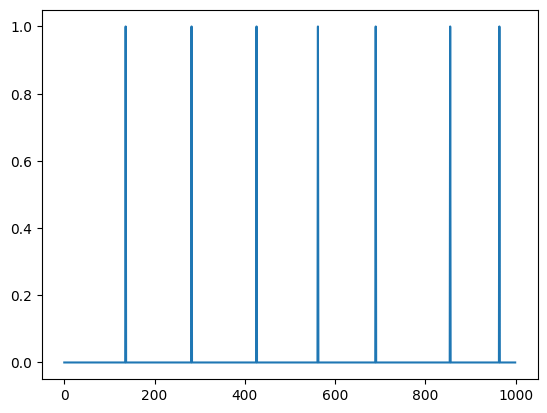

In [12]:
X = np.zeros(len(Vc))
X[stim_onsets_abs_samples] = 1
plt.plot(X[:1000])

In [13]:
max_lag = 50
n = len(X)
X_lagged = np.zeros((n, max_lag))
for lag in range(max_lag):
    X_lagged[lag:, lag] = X[:n-lag]

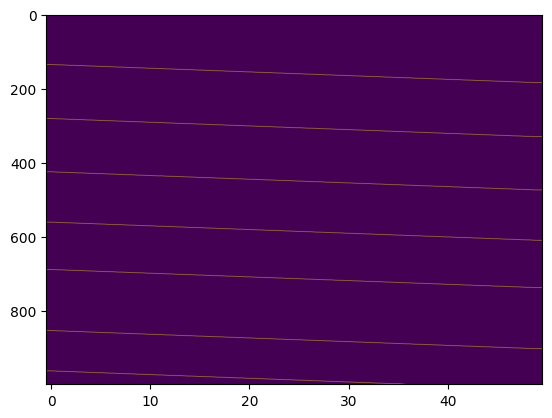

In [14]:
plt.imshow(X_lagged[:1000, :], aspect="auto")

In [15]:
y = Vc[:, 0]
y.shape

(41623,)

No intercept, no regularization

In [16]:
b = np.linalg.solve(X_lagged.T @ X_lagged, X_lagged.T @ y)

In [17]:

ds = xr.Dataset(
    {
        "regressor": ("time", X),
        "response": (("time", "component"), Vc),
    },
    coords={
        "time": np.arange(len(X)) / fs,
        "component": np.arange(Vc.shape[1])},
    attrs={"fs": fs},
)
# 

In [19]:
ds

<xarray.Dataset> Size: 84MB
Dimensions:    (time: 41623, component: 500)
Coordinates:
  * time       (time) float64 333kB 0.0 0.03301 0.06602 ... 1.374e+03 1.374e+03
  * component  (component) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
Data variables:
    regressor  (time) float64 333kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    response   (time, component) float32 83MB -6.169 9.462 ... -0.3101 0.07893
Attributes:
    fs:       30.292913412780123

In [20]:
ds.to_netcdf("..\data\data1.nc")